<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li></ul></div>

# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import (    
    r2_score,
    mean_absolute_error,
    mean_squared_error

)
from sklearn.utils import shuffle
from tqdm import tqdm 
from joblib import dump
pd.options.mode.chained_assignment = None

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
try:
    geo_data_0 = pd.read_csv('D:\\Мои документы\\DS\\geo_data_0.csv')
    geo_data_1 = pd.read_csv('D:\\Мои документы\\DS\\geo_data_1.csv')
    geo_data_2 = pd.read_csv('D:\\Мои документы\\DS\\geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

**Согласно документации в трех датафреймах содержатся данные геологоразведки трёх регионов:**

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

- Наименования колонок соответствуют "змеиному" стилю.
- Названия колонок соответствуют документации.
- Пропущенные значения нет.
- Данные в столбцах соответствуют тому типу, в котором хранится в них информация.

Создадим функцию для описания данных

In [3]:
def info_data(data):
    print(data.info())    
    data.hist(figsize=(10, 7));   
    plt.show()
    plt.figure(figsize=(6, 5))
    plt.title('Матрица корреляций')   
    sns.heatmap(data.corr(), annot = True)
    plt.show()
    data.boxplot( vert=False, figsize=(15, 5))
    plt.title('Распределение признаков')
    plt.show();

In [4]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


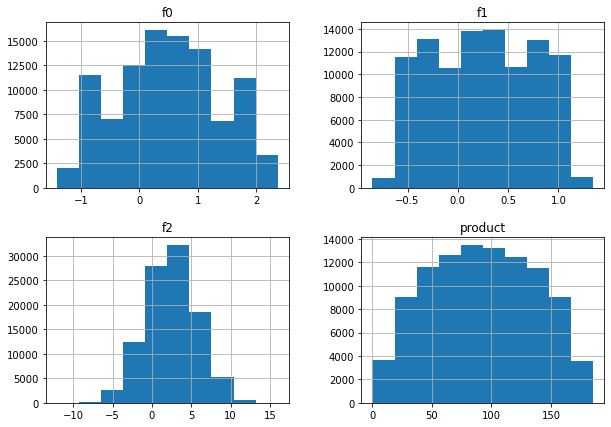

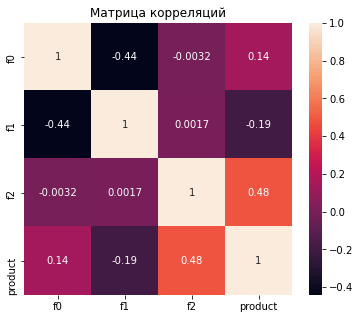

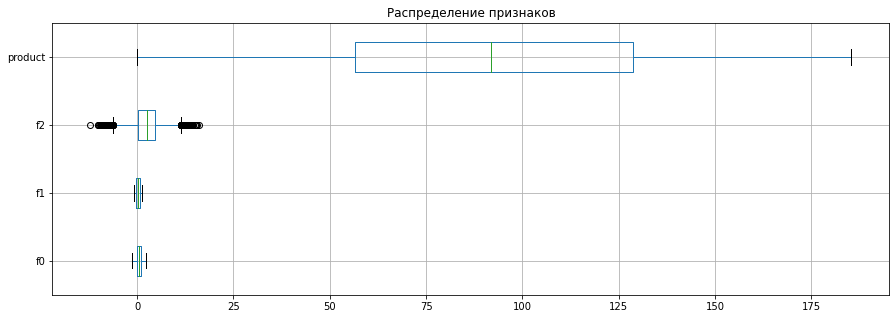

In [5]:
info_data(geo_data_0)

- В таблице 5 столбцов и 100000 строк.
- Данные распределены нормально.
- Есть выбросы у ``f2``
- Параметр ``product`` слабо коррелирует с остальными параметрами.
- Больше всего коррелирует параметр ``f2`` и ``product``, но всего на 0,48. 

In [6]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


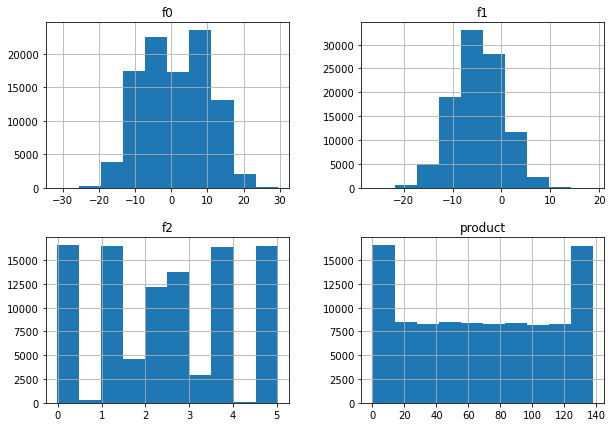

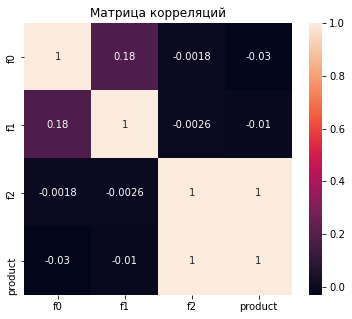

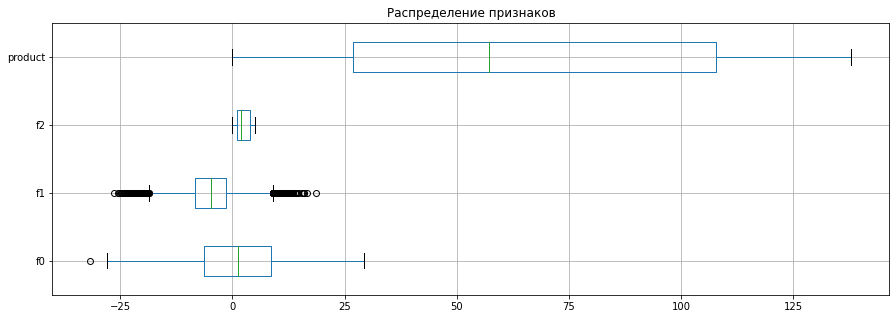

In [7]:
info_data(geo_data_1)

- В таблице 5 столбцов и 100000 строк.
- Данные распределены нормально только у признаков ``f0`` и ``f1``, остальные имеют несколько пиков.
- Есть выбросы у ``f1`` и ``f0``
- Параметр ``product`` и ``f2``полностью взаимосвязаны - величина коэффициента корреляции равна 1

In [8]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


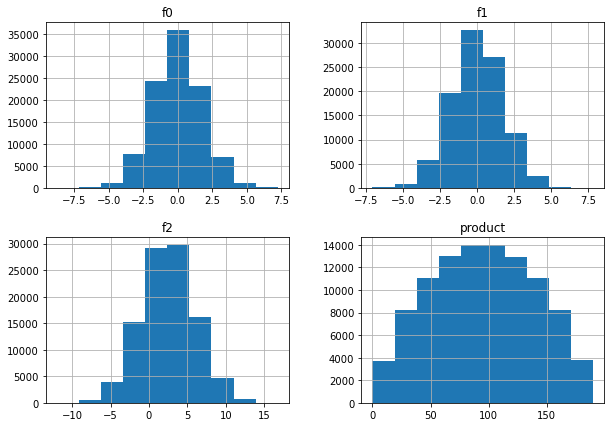

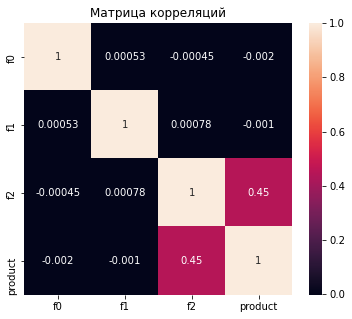

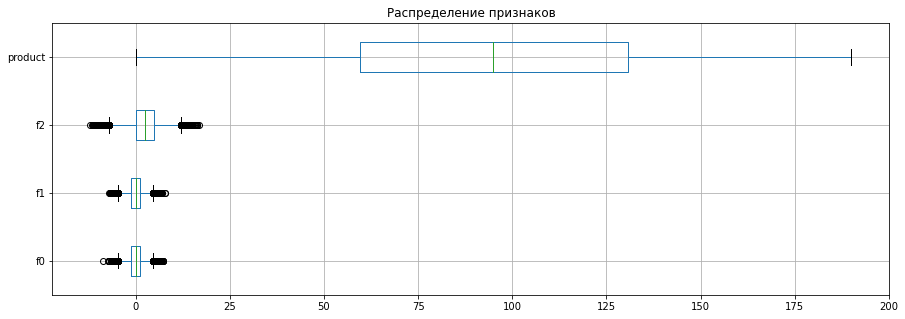

In [9]:
info_data(geo_data_2)

- В таблице 5 столбцов и 100000 строк.
- Данные распределены нормально.
- Есть выбросы у ``f0``,``f1``,``f2``
- Параметр ``product`` слабо коррелирует с остальными параметрами.
- Больше всего коррелирует параметр ``f2`` и ``product``, но всего на 0,45. 

**Устранение дубликатов**

Проверим наличие явных дубликатов

In [10]:
print(geo_data_0.duplicated().sum()) 
print(geo_data_1.duplicated().sum()) 
print(geo_data_2.duplicated().sum()) 

0
0
0


Явных дубликатов в данных нет.

Посмотрим сколько дубликатов в ``id — уникальный идентификатор скважины`` у нас в данных, и не имеются ли неявные дубликаты.

In [11]:
print(geo_data_0['id'].duplicated().sum()) 
print(geo_data_1['id'].duplicated().sum()) 
print(geo_data_2['id'].duplicated().sum()) 

10
4
4


In [12]:
geo_data_0['id'].value_counts().head(11)

A5aEY    2
AGS9W    2
HZww2    2
bxg6G    2
74z30    2
bsk9y    2
TtcGQ    2
Tdehs    2
fiKDv    2
QcMuo    2
iXO43    1
Name: id, dtype: int64

In [13]:
geo_data_0[geo_data_0['id']=='Tdehs']

,id,f0,f1,f2,product
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
75715,Tdehs,0.112079,0.430296,3.218993,60.964018


In [14]:
geo_data_1['id'].value_counts().head(5)

bfPNe    2
LHZR0    2
wt4Uk    2
5ltQ6    2
hc2DS    1
Name: id, dtype: int64

In [15]:
geo_data_1[geo_data_1['id']=='wt4Uk']

,id,f0,f1,f2,product
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [16]:
geo_data_2['id'].value_counts().head(5)

Vcm5J    2
KUPhW    2
VF7Jo    2
xCHr8    2
aRv8z    1
Name: id, dtype: int64

In [17]:
geo_data_2[geo_data_2['id']=='KUPhW']

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802


Несмотря на наличие дубликатов в ``id — уникальный идентификатор скважины`` вряд ли эти данные можно назвать дубликатами, все  остальные признаки сильно отличаются. Т.к. **id мы удалим, нам для обучения модели этот столбец не понадобится.** Строки с дублирующими значениями в id удалять не станем.

**Вывод:**

- Каждый датасете содежится 100 тыс. строк и 5 столбцов.
- Признак ``f2`` имеет среднюю корреляцию с целевым признаком.
- В регионе 1 величина коэффициента корреляции  с ``f2``равна 1.
- В регионе 0 в признаке - ``f2``. Выбросы в целевом признаке отсутствуют в данных всех регионов.В регионе 1 выбросы имеются в признаках ``f0``, ``f1``.  В регионе 2 все признаки имеют выбросы в данных. 
- В столбце ``id`` есть несколько повторяющихся значений. Для обучения модели он не нужен.
- Пропущенных значений, полных дубликатов не обнаружено.

## Обучение и проверка модели

In [18]:
def separation(data): # создадим функция для разделения данных на целевой признак и на признаки
    features = data.drop(['product','id'], axis=1)
    target = data['product']    
    return features,target

In [19]:
def separ_2(features, target): # функция для разделение на выборки обуч. 75% и вал. 25%
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)# отделим 75% данных для обучающей выборки
    print('размер обучающей выборки:',features_train.shape)
    print('размер валидационной выборки:',features_valid.shape)
    sns.kdeplot(data=features_train, fill=True, common_norm=False, 
        alpha=.3, linewidth=1).set(
    title="Распределение признаков")
    plt.show()
    return features_train, features_valid, target_train, target_valid


In [20]:
features_0, target_0 = separation(geo_data_0)
features_1, target_1 = separation(geo_data_1)
features_2, target_2 = separation(geo_data_2)

размер обучающей выборки: (75000, 3)
размер валидационной выборки: (25000, 3)


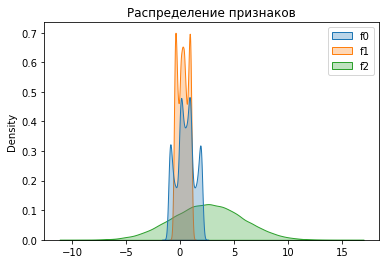

In [21]:
features_0_train, features_0_valid, target_0_train, target_0_valid=separ_2(features_0, target_0)

размер обучающей выборки: (75000, 3)
размер валидационной выборки: (25000, 3)


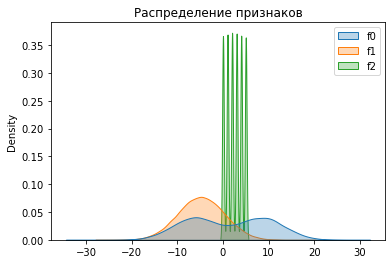

In [22]:
features_1_train, features_1_valid, target_1_train, target_1_valid=separ_2(features_1, target_1)

размер обучающей выборки: (75000, 3)
размер валидационной выборки: (25000, 3)


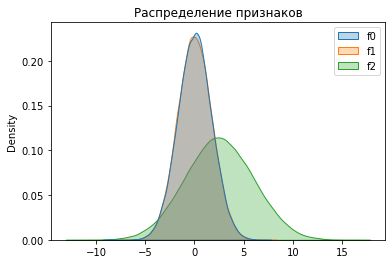

In [23]:
features_2_train, features_2_valid, target_2_train, target_2_valid=separ_2(features_2, target_2)

Стандартизация признаков не требуется

Обучим модель. Напечатаем на экране средний запас предсказанного сырья и R2,MAE, RMSE модели.

In [24]:
def model_metric(features_train, features_valid, target_train, target_valid):
    model = LinearRegression() 
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    print('средний запас предсказанного сырья: {:.4f}'.format(predicted.mean()))
    print('R2: {:.4f}'.format(r2_score(target_valid, predicted)))
    print('MAE: {:.4f}'.format(mean_absolute_error(target_valid, predicted)))
    print('RMSE: {:.4f}'.format(mean_squared_error(target_valid, predicted)** 0.5))
    return predicted

In [25]:
predicted_0=model_metric(features_0_train, features_0_valid, target_0_train, target_0_valid)

средний запас предсказанного сырья: 92.5926
R2: 0.2799
MAE: 30.9196
RMSE: 37.5794


R2 близка нулю: модель работает так же, как и среднее.

In [26]:
predicted_1=model_metric(features_1_train, features_1_valid, target_1_train, target_1_valid)

средний запас предсказанного сырья: 68.7285
R2: 0.9996
MAE: 0.7188
RMSE: 0.8931


Значение метрики R2 почти равно единице. Такая модель предсказывает все ответы идеально.

In [27]:
predicted_2=model_metric(features_2_train, features_2_valid, target_2_train, target_2_valid)

средний запас предсказанного сырья: 94.9650
R2: 0.2052
MAE: 32.7927
RMSE: 40.0297


R2 близка нулю: модель работает так же, как и среднее.

**Вывод:**

- Лучший результат предсказаний согласно метрик RMSE и R2 и MAE показала модель для региона 1. RMSE - 0,89 что говорит о высокой точности предсказаний. R2 близка к 1 (R2= 0.9996), что говорит о высоком качестве предсказаний.
- Стоит учесть, что  в этом регионе средний запас сырья - 68,73 - наименьший среди трех регионов (в 0 -92.59, в 2 - 94.97)

## Подготовка к расчёту прибыли

**Условия задачи:**
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [28]:
study = 500
development = 200
budget = 10000000
income = 450
lesion = 0.025

In [29]:
min_count=budget/development/income
print('Минимальное среднее количество продукта в месторождениях региона, достаточное для разработки: {:.2f} тыс. тон'.
      format(min_count))


Минимальное среднее количество продукта в месторождениях региона, достаточное для разработки: 111.11 тыс. тон


In [30]:
def revenue(target, probabilities, count,income, budget): # создаём функцию для подсчета прибыли
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    profit=income * selected.sum()-budget
    volume=selected.sum()
    selected_mean=selected.mean()
    return volume, profit, selected_mean

In [31]:
def income_def (target, predicted, study,development, budget, lesion,income):  # cсоздадим функцию для Bootstrap 
    state = np.random.RandomState(12345)
    target=target.reset_index(drop=True)
    profit_sample = []
    volume_sample=[]
    income=income
    for i in range(1000):
        target_subsample = target.sample(n=study, replace=True, random_state=state)
        probs_subsample = pd.Series(predicted)[target_subsample.index]
        volume, profit, selected_mean = revenue(target_subsample, probs_subsample, development, income, budget)
        
        profit_sample.append(profit)        
        volume_sample.append(volume)

    profit_sample = pd.Series(profit_sample)     
    profit_mean = profit_sample.mean()
    lower = profit_sample.quantile(lesion)# доверительный интервал 95 начало 
    upper  = profit_sample.quantile(1-lesion) # доверительный интервал 95 конец
    risk = (profit_sample < 0).mean()*100     
    
    volume_sample = pd.Series(volume_sample)
    volume_mean = volume_sample.mean()
    print("Средний объем месторождения:", round(selected_mean, 2), 'тыс.тон')
    print("Средний общий объем по региону:", round(volume_mean, 2), 'тыс.тон')
    print("Средняя прибыль:", round(profit_mean, 2), 'тыс.руб')
    print("Риск убытка:", round(risk, 3), '%')
    print("Доверительный интервал: от", round(lower, 2),'до ', round(upper, 2) )
           
    return profit_mean,volume_mean,selected_mean,risk    

## Расчёт прибыли и рисков 

In [32]:
profit_mean_0,volume_mean_0,selected_mean_0, risk_0 = income_def(target_0_valid,predicted_0, 
                                                                 study,development, budget, lesion,income)

Средний объем месторождения: 113.32 тыс.тон
Средний общий объем по региону: 23168.75 тыс.тон
Средняя прибыль: 425938.53 тыс.руб
Риск убытка: 6.0 %
Доверительный интервал: от -102090.09 до  947976.35


In [33]:
profit_mean_1,volume_mean_1,selected_mean_1, risk_1=income_def(target_1_valid,predicted_1,
                                                               study,development, budget, lesion,income)

Средний объем месторождения: 113.05 тыс.тон
Средний общий объем по региону: 23367.16 тыс.тон
Средняя прибыль: 515222.77 тыс.руб
Риск убытка: 1.0 %
Доверительный интервал: от 68873.23 до  931547.59


In [34]:
profit_mean_2,volume_mean_2,selected_mean_2,risk_2 =income_def(target_2_valid,predicted_2, 
                                                               study,development, budget, lesion,income)

Средний объем месторождения: 112.46 тыс.тон
Средний общий объем по региону: 23188.91 тыс.тон
Средняя прибыль: 435008.36 тыс.руб
Риск убытка: 6.4 %
Доверительный интервал: от -128880.55 до  969706.95


In [35]:
region = ['регион_0', 'регион_1', 'регион_2']
profit =[profit_mean_0,profit_mean_1,profit_mean_2]
volume=[volume_mean_0,volume_mean_1,volume_mean_2]
selected=[selected_mean_0,selected_mean_1,selected_mean_2]
risk=[risk_0, risk_1, risk_2]

best_region = pd.DataFrame({'Регион':region,'Средняя прибыль':profit, 
                            'Ср. объем по региону':volume,'Ср. объем месторождения':selected,'Риск убытков %':risk})
best_region.sort_values(by='Средняя прибыль', ascending=False)

,Регион,Средняя прибыль,Ср. объем по региону,Ср. объем месторождения,Риск убытков %
1,регион_1,515222.773443,23367.161719,113.050270,1.0
2,регион_2,435008.362783,23188.907473,112.458558,6.4
0,регион_0,425938.526911,23168.752282,113.320225,6.0


**Вывод:**

- Все три региона имеют минимальное среднее количество продукта в месторождениях региона, достаточное для разработки, и оно превышает 111.11
- Наименьший риск получения убытков во регионе 1 он составил 1 %. Риск убытков в регионе 0 - 6 %, в регионе 2 - 6,4 %.
- Наибольшую прибыль показал регион 1 в 515222,773 тыс. руб.
- 95% доверительный интервал региона 1 от от 68873.23 до  931547.59 тыс. руб.

**ВЫВОД:**

Для дальнейшей разработки нефтяных скважин по итогам исследования стоит расмотреть  регион № 1.